In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, SVDpp, NMF
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import accuracy
from surprise.model_selection import train_test_split
import numpy as np


ratings = pd.read_csv('ml-latest-small/ratings.csv')
print(f"Ratings dataset shape: {ratings.shape}")
ratings.head()

Ratings dataset shape: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [2]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

trainset_size = sum(1 for _ in trainset.all_ratings())
testset_size = len(testset)

print(f"Trainset size: {trainset_size}")
print(f"Testset size: {testset_size}")

Trainset size: 75627
Testset size: 25209


In [3]:
# Function to perform grid search and return the best model and its performance
def perform_grid_search(algo, param_grid, data):
    gs = GridSearchCV(algo, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=5)
    gs.fit(data)
    best_algo = gs.best_estimator['rmse']
    best_params = gs.best_params['rmse']
    return best_algo, best_params

In [4]:
param_grid_svd = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

# Perform GridSearchCV for SVD
best_svd, best_params_svd = perform_grid_search(SVD, param_grid_svd, data)
print(f"Best SVD parameters: {best_params_svd}")

# Train and evaluate the best SVD model
best_svd.fit(trainset)
predictions_svd = best_svd.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)
print(f"SVD RMSE: {rmse_svd}, MAE: {mae_svd}")

# Perform 3-fold cross-validation
cv_results_svd = cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(f"Average RMSE: {np.mean(cv_results_svd['test_rmse'])}")
print(f"Average MAE: {np.mean(cv_results_svd['test_mae'])}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  56 out of  72 | elapsed:    8.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   10.9s finished


Best SVD parameters: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}
RMSE: 0.8680
MAE:  0.6683
SVD RMSE: 0.8680284261605721, MAE: 0.6683206319432304
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8729  0.8722  0.8688  0.8713  0.0018  
MAE (testset)     0.6698  0.6709  0.6688  0.6698  0.0009  
Fit time          1.03    1.01    1.00    1.02    0.01    
Test time         0.13    0.13    0.09    0.12    0.02    
Average RMSE: 0.8712925417568192
Average MAE: 0.669844024433448


In [6]:
param_grid_svdpp = {
    'n_factors': [20, 50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.007, 0.01],
    'reg_all': [0.02, 0.1]
}

# Perform GridSearchCV for SVD++
best_svdpp, best_params_svdpp = perform_grid_search(SVDpp, param_grid_svdpp, data)
print(f"Best SVD++ parameters: {best_params_svdpp}")

# Train and evaluate the best SVD++ model
best_svdpp.fit(trainset)
predictions_svdpp = best_svdpp.test(testset)
rmse_svdpp = accuracy.rmse(predictions_svdpp)
mae_svdpp = accuracy.mae(predictions_svdpp)
print(f"SVD++ RMSE: {rmse_svdpp}, MAE: {mae_svdpp}")

# Perform 3-fold cross-validation
cv_results_svdpp = cross_validate(best_svdpp, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(f"Average RMSE: {np.mean(cv_results_svdpp['test_rmse'])}")
print(f"Average MAE: {np.mean(cv_results_svdpp['test_mae'])}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  56 out of  72 | elapsed: 11.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 15.5min finished


Best SVD++ parameters: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
RMSE: 0.8545
MAE:  0.6570
SVD++ RMSE: 0.8545192159481132, MAE: 0.6570354586270487
Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8640  0.8598  0.8580  0.8606  0.0025  
MAE (testset)     0.6631  0.6590  0.6588  0.6603  0.0020  
Fit time          163.07  163.72  163.06  163.28  0.31    
Test time         6.92    6.87    6.93    6.90    0.02    
Average RMSE: 0.8606183565323223
Average MAE: 0.6602822515168704


In [5]:
param_grid_nmf = {
    'n_factors': [15, 30, 40],
    'n_epochs': [30, 50],
    'reg_pu': [0.06, 0.1],
    'reg_qi': [0.06, 0.1]
}

# Perform GridSearchCV for NMF
best_nmf, best_params_nmf = perform_grid_search(NMF, param_grid_nmf, data)
print(f"Best NMF parameters: {best_params_nmf}")

# Train and evaluate the best NMF model
best_nmf.fit(trainset)
predictions_nmf = best_nmf.test(testset)
rmse_nmf = accuracy.rmse(predictions_nmf)
mae_nmf = accuracy.mae(predictions_nmf)
print(f"NMF RMSE: {rmse_nmf}, MAE: {mae_nmf}")

# Perform 3-fold cross-validation
cv_results_nmf = cross_validate(best_nmf, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(f"Average RMSE: {np.mean(cv_results_nmf['test_rmse'])}")
print(f"Average MAE: {np.mean(cv_results_nmf['test_mae'])}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  56 out of  72 | elapsed:   11.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   14.7s finished


Best NMF parameters: {'n_factors': 40, 'n_epochs': 50, 'reg_pu': 0.1, 'reg_qi': 0.1}
RMSE: 0.8965
MAE:  0.6870
NMF RMSE: 0.8965287881933884, MAE: 0.6870328230954402
Evaluating RMSE, MAE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9115  0.8979  0.9027  0.9040  0.0056  
MAE (testset)     0.6968  0.6881  0.6899  0.6916  0.0037  
Fit time          1.74    1.76    1.72    1.74    0.01    
Test time         0.12    0.12    0.07    0.10    0.02    
Average RMSE: 0.9040248026175438
Average MAE: 0.6916042000022192


In [7]:
# Creating a DataFrame to compare RMSE and MAE results for all models
results_rmse = pd.DataFrame({
    'SVD': cv_results_svd['test_rmse'],
    'SVD++': cv_results_svdpp['test_rmse'],
    'NMF': cv_results_nmf['test_rmse']
})

results_mae = pd.DataFrame({
    'SVD': cv_results_svd['test_mae'],
    'SVD++': cv_results_svdpp['test_mae'],
    'NMF': cv_results_nmf['test_mae']
})

# Determining the best model based on RMSE
best_model_rmse = min(results_rmse.items(), key=lambda x: x[1][0])[0]
print(f"The best model based on RMSE is {best_model_rmse}")

# Determining the best model based on MAE
best_model_mae = min(results_mae.items(), key=lambda x: x[1][1])[0]
print(f"The best model based on MAE is {best_model_mae}")

The best model based on RMSE is SVD++
The best model based on MAE is SVD++


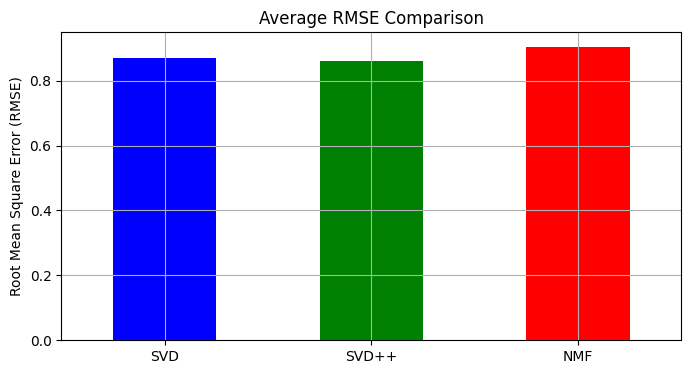

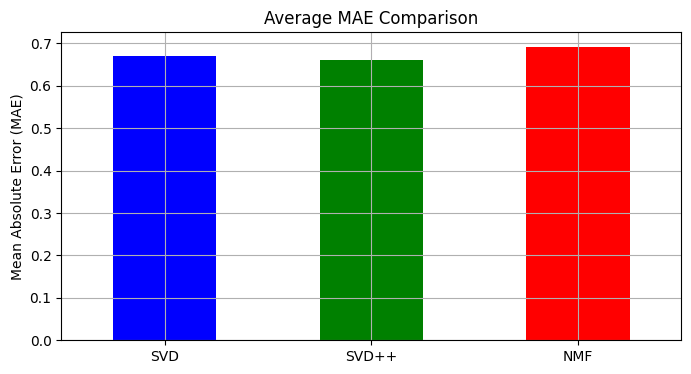

In [8]:
avg_rmse = results_rmse.mean()
avg_mae = results_mae.mean()

plt.figure(figsize=(8, 4))
avg_rmse.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Average RMSE Comparison')
plt.ylabel('Root Mean Square Error (RMSE)')
plt.xticks(rotation=0)
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
avg_mae.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Average MAE Comparison')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(rotation=0)
plt.grid()
plt.show()